# Loan Prosecution

**Installing Requirements**

In [1]:
# install required packages
!pip install -r requirements.txt -q

**Loading Libraries**

In [2]:
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    from sklearn.utils import resample
    import matplotlib.pyplot as plt
    import seaborn as sns
    import shap
    import lime
    import lime.lime_tabular
    from ucimlrepo import fetch_ucirepo


**Loading Data**

In [3]:
# Load the Adult dataset from OpenML
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

df = df.dropna()
df = df.copy()
print(df.shape)
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

# print column and data type
for col in df.columns:
    print(f"{col}: {df[col].dtype}")



(45222, 15)
age: int64
workclass: category
fnlwgt: int64
education: category
education-num: int64
marital-status: category
occupation: category
relationship: category
race: category
sex: category
capital-gain: int64
capital-loss: int64
hours-per-week: int64
native-country: category
class: category


In [4]:
# Fetch and prep data
adult = fetch_ucirepo(id=2)
df = adult.data.features
df['class'] = adult.data.targets
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# Correctly encode labels
label_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'class']
encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# --- CORRECTED MODEL TRAINING ---
# The target 'y' is now correctly assigned from the encoded 'class' column
X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"]

# Use stratify for a balanced train/test split, which is good practice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Retrain the model on the correctly prepared data
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)

# Create Jane's profile for testing
jane_decoded = {
    'age': 37, 'workclass': 'Private', 'education': 'Bachelors', 'education-num': 13,
    'marital-status': 'Never-married', 'occupation': 'Exec-managerial',
    'relationship': 'Not-in-family', 'race': 'White', 'sex': 'Female',
    'capital-gain': 0, 'capital-loss': 0, 'hours-per-week': 50,
    'native-country': 'United-States',
}
jane_encoded = {key: encoders[key].transform([value])[0] if key in encoders else value for key, value in jane_decoded.items()}
jane_df = pd.DataFrame([jane_encoded])[X_train.columns]

**Exploratory Data Analysis**

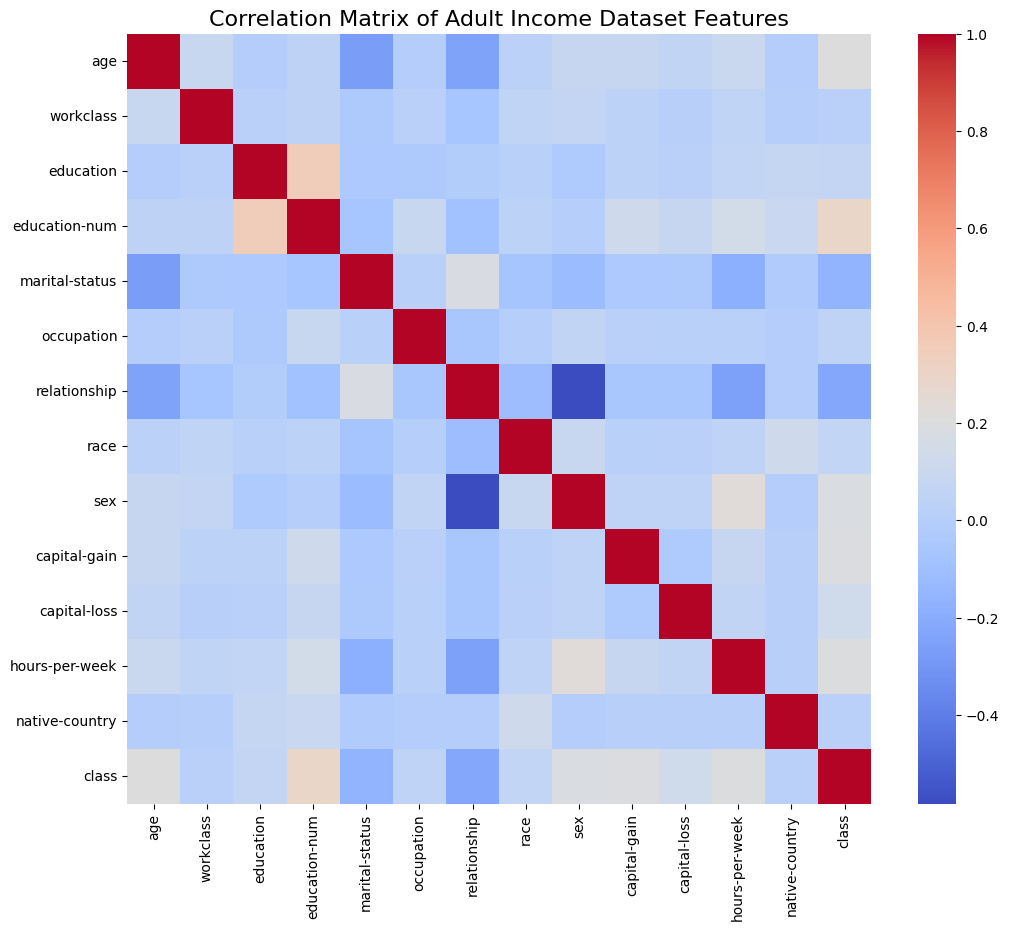

In [5]:
# --- Correlation Matrix Calculation and Visualization ---
# Create a copy of the dataframe for the correlation matrix, dropping the 'fnlwgt' column
corr_df = df.drop('fnlwgt', axis=1)

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# Create the heatmap visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Adult Income Dataset Features', fontsize=16)
plt.show()


**Interpretation**
- capital-gain and class: This is one of the strongest predictors. Having capital gains is strongly associated with a higher income
- hours-per-week and class: People who work more hours per week tend to have a higher income.
- education-num and education: they are essentially two different representations of the same information (level of education)
- relationship and class: This is a key finding for your case. There is a strong negative correlation, which suggests that being in certain relationship categories
- marital-status and class: A similar negative correlation exists here, indicating that certain marital statuses (like 'Never-married') are associated with a lower income class

### SHAP

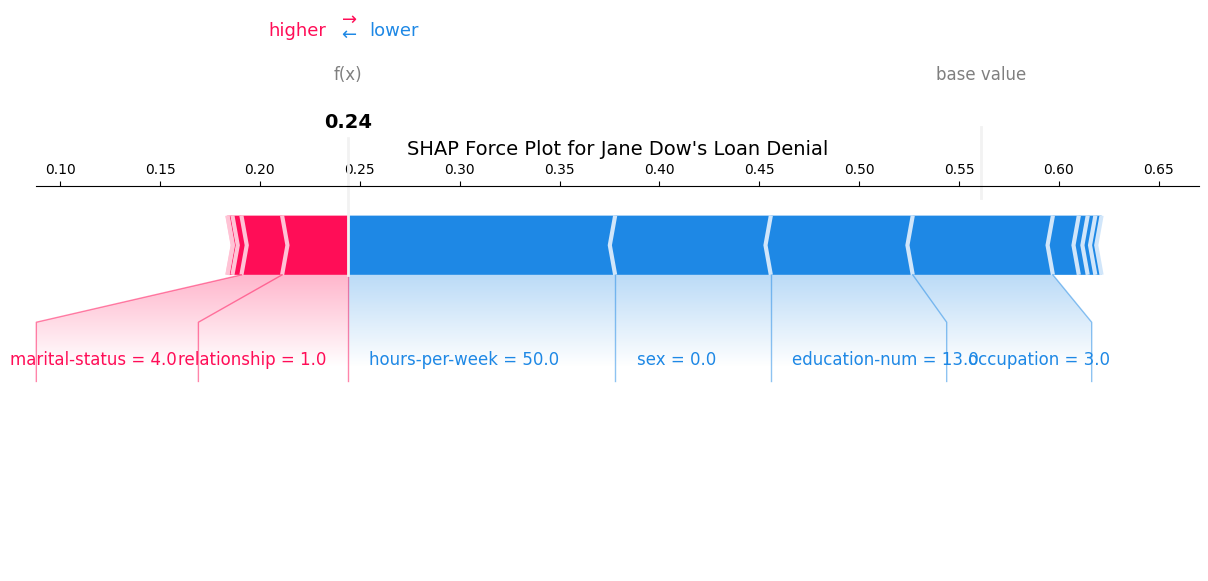

100%|===================| 797/800 [02:09<00:00]        

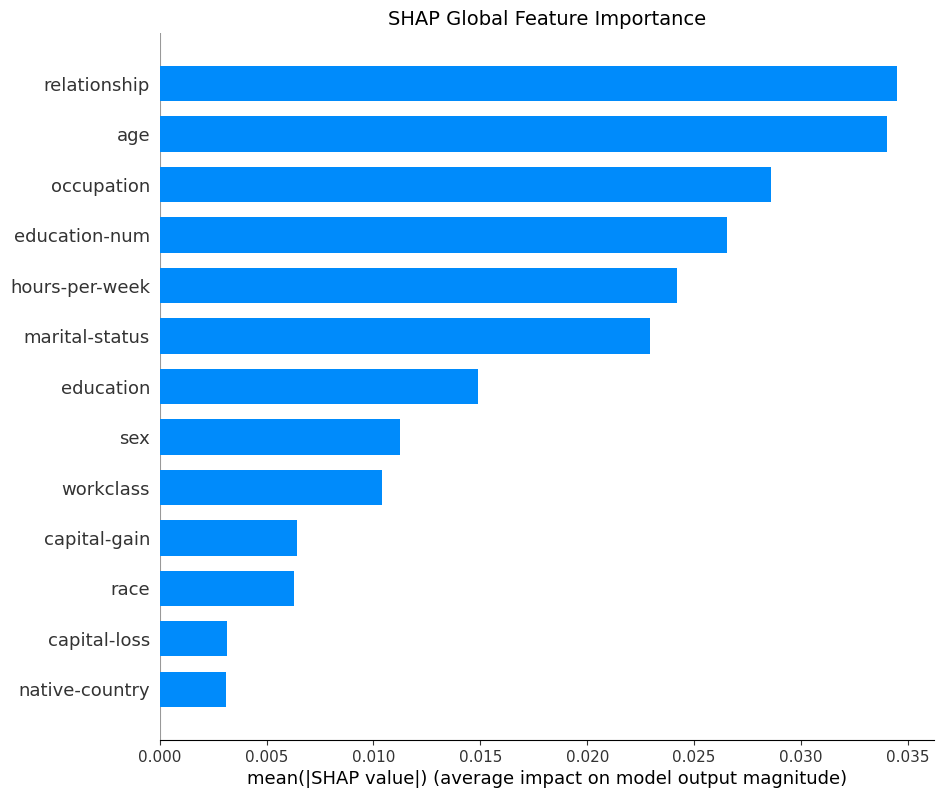

In [6]:
# --- SHAP Implementation (Corrected for Performance) ---
# Create a background dataset (a small sample of the training data)
# This is a best practice that improves performance.
background_data = shap.sample(X_train, 100)
explainer = shap.TreeExplainer(model_adult, background_data)

# --- The force plot for a single instance is fast and needs no changes ---
shap_explanation_jane = explainer(jane_df)

# Visualization 1: SHAP Force Plot
shap.force_plot(
    shap_explanation_jane[0, :, 0],
    matplotlib=True,
    show=False
)
plt.title("SHAP Force Plot for Jane Dow's Loan Denial", fontsize=14)
plt.gcf().set_size_inches(15, 5)
plt.show()

# --- The summary plot also uses the new object ---
# FIX: Reduce the sample size from 1000 to 200 for faster computation.
X_test_sample = X_test.sample(200, random_state=42)
shap_explanation_test = explainer(X_test_sample)

# Visualization 2: SHAP Summary Plot
shap.summary_plot(
    shap_explanation_test[:, :, 1],
    X_test_sample,
    plot_type="bar",
    show=False
)
plt.title('SHAP Global Feature Importance', fontsize=14)
plt.gcf().set_size_inches(10, 8)
plt.show()

**SHAP Interpretation**

- The first of the SHAP chart shows how for Jane the model decision strongly penalized her because of her gender, which should not be a factor when deciding whether a loan is underwritten or not. 
- Additionally some variables that should in theory support Jane getting a loan were weighted towards her being rejected. They are high education level (education-num = 13.0), being an executive (occupation = 3.0), and working 50 hours a week. 
- The Second Chart shows how for many of the observations facotrs like someone's age or relationship status are being used as  regressors of strong decision magnitude towards the final loan underwriting rules. While assessing someone's creditworthiness by having a job, education, and occupation are of importance, the main drivers of a credit decision are associated with someone's relationship or age in this prediction mechanism


**SHAP Conclusion** A model that punishes applicants for professional attributes that  makes them creditworthy should be revised and exclude gender dicrimination, age discrimination, and favor positively elements such such as working hours or someone's position within a company. 

### LIME

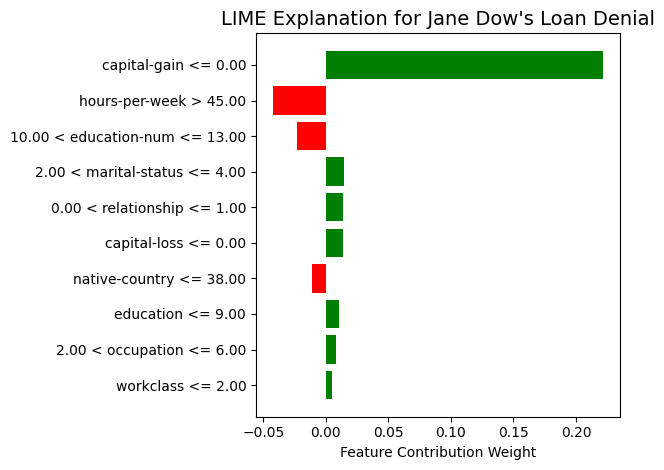

In [7]:
# --- LIME Implementation (Corrected) ---
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['<=50K', '>50K'],
    mode='classification'
)

# Create a wrapper function to ensure data passed to the model has feature names
predict_fn_wrapper = lambda x: model_adult.predict_proba(pd.DataFrame(x, columns=X_train.columns))

# Use the wrapper function in the explainer
explanation_lime = explainer_lime.explain_instance(
    jane_df.iloc[0].values,
    predict_fn_wrapper,
    num_features=10
)

# Visualization 1: LIME Explanation Plot
fig = explanation_lime.as_pyplot_figure()
plt.title("LIME Explanation for Jane Dow's Loan Denial", fontsize=14)
plt.xlabel("Feature Contribution Weight")
plt.tight_layout()
plt.show()

**Lime Interpretation**

- While it correctly identifies a lack of capital gains as a negative factor, the LIME method also lists Jane's marital and relationship statuses as reasons supporting her loan denial.
- The model is ineffectively using someone's relationship, nationality, or marital status for a decision that could be easily deemed discriminatory while favoring, at a lower scale, elements like education, working hours, and job title.

**LIME Conculsion** This model further reinforces how, for Jane and potentially many other applicants, loan decisions are being strongly determined by discriminatory biases as opposed to attributes related to someone's career stability and professional factors.
